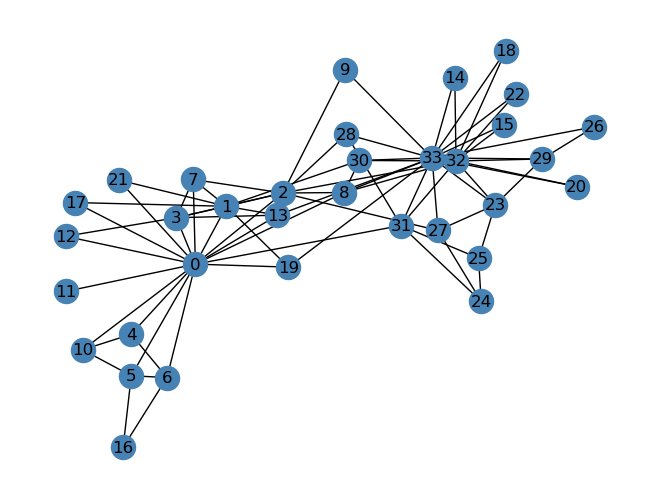

In [2]:
import networkx as nx
G = nx.karate_club_graph()
layout = nx.layout.fruchterman_reingold_layout(G)
nx.draw(G, layout, with_labels=True, node_color = "steelblue")

We need to return a vector of binary labels to split the graph.

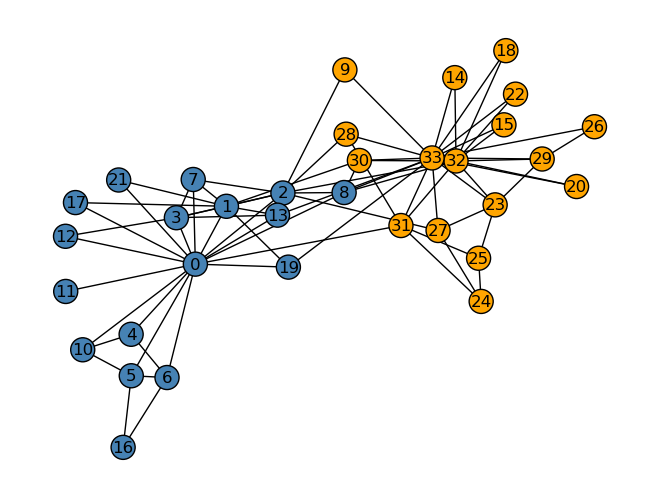

In [4]:
clubs = nx.get_node_attributes(G, "club")

nx.draw(G, layout,
        with_labels=True, 
        node_color = ["orange" if clubs[i] == "Officer" else "steelblue" for i in G.nodes()],
        edgecolors = "black" # confusingly, this is the color of node borders, not of edges
        ) 


$$\mathcal{L}(a, b) = \sum_{i = 1}^n (ax_i + b - y_i)^2\;.$$
